In [1]:
##########################
#    Necessary imports   #
##########################

from SIGMA_GP_PP_Gibbs  import *

f_init = time.time()

#ot.RandomGenerator.SetSeed(0) # Make results reproducible by freezing Open TURNS's random generator's seed
#np.random.seed(0) # Make results reproducible by freezing Numpy's random generator's seed


/home/H01971/miniforge3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:



####################
# Generative model #
####################

# Assuming square domain [0,1]*[0,1] (surface 1)
# and null trend

lambdaBar = 10
T = 50

def U(xy):
    u = [0, 0]
    u[0] = (xy[0]>0.5)*(xy[1]>0.5) + (xy[0]<=0.5)*(xy[1]<=0.5)
    u[1] = 1 - u[0]
    return u

U_OT = ot.PythonFunction( 2, 2, U )
Sigma_eps = ot.CovarianceMatrix( np.eye(2)*1E-1 ) 
PrecEps = Sigma_eps.inverse()
J = 2

# Add piecewise constant trend
EpsTrue = np.array( ot.Normal( ot.Point(J), Sigma_eps ).getRealization() ).reshape(-1,1)*100
# Utot = np.array( U_OT( XY_star ) )
# mTot = np.dot( Utot, EpsTrue )

def trend(X, eps=EpsTrue):
    Utot = np.array( U_OT( X ) )
    mTot = np.dot( Utot, eps )
    return mTot

# GP model specification
covarianceModel = ot.SquaredExponential([0.5, 0.5], [10.0])
m = ot.PythonFunction(2, 1, trend)

# Homogeneous augmented Poisson process Size
Poisson = ot.Poisson(lambdaBar * T)

# Upper bound on size of augmented Poisson process
Nmax = int(Poisson.computeQuantile(1-1e-20)[0])*2

# Zoning covariables : two zones with a four-sided intersection point
J = 2 # number of zones

# where to save results (figures)
savedir = os.path.join( os.environ['HOME'], "sigma_gp_results")
if not os.path.exists(savedir): os.mkdir( savedir )


In [3]:
###################
# Data generation #
###################

# Simulate according to homogogeneous Poisson process
N_star = int(Poisson.getRealization()[0])
myUniform = ot.ComposedDistribution([ot.Uniform(0, 1)]*2)
XY_star = myUniform.getSample(N_star)
mesh = ot.Mesh(XY_star)

# apply trend function to mesh and create Gaussian process
mTrend = ot.TrendTransform(m, mesh)
Ftot = ot.GaussianProcess(mTrend, covarianceModel, mesh)

# Sigma GP process
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)
process = ot.CompositeProcess(field_function, Ftot) 

field_f = process.getRealization()
    
# Use thinning
p_accept = np.array( field_f.getValues() )
accepted = np.array( ot.Uniform(0, 1).getSample(N_star) ) <= p_accept 
accepted = accepted.ravel()
N = accepted.sum()
Ntot = len(accepted)
NPi = Ntot - N

# Assemble Augmented (Obs + Latent) Poisson process
# /!\ Zero-padded to reach Nmax length
D = np.array( XY_star )[accepted]
Pi = np.array( XY_star )[accepted==False]

Dtot = np.vstack((D,Pi,[[0,0]]*(Nmax-Ntot)))

# Assemble Augmented (Obs + Latent) Gaussian process
# /!\ Zero-padded to reach Nmax length
fD = np.array(field_f)[accepted]
fPi = np.array(field_f)[accepted==False]
ftot = np.vstack((fD,fPi,[[0]]*(Nmax-Ntot)))

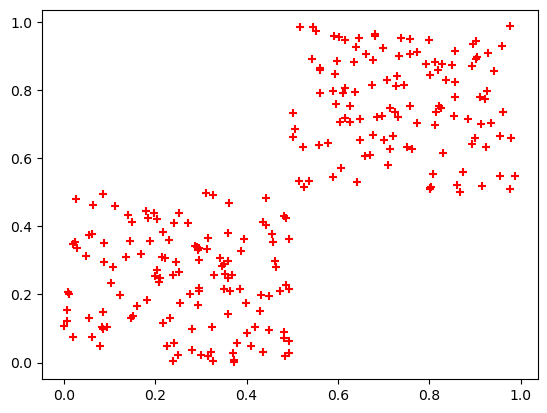

In [4]:
#######################
# TEST ON TOY DATASET #
#######################

# Plot the data
fig = plt.figure()
plt.scatter( D[:,0], D[:,1], c="r", marker="+" )
# plt.show()
plt.savefig(os.path.join(savedir, "Data.png"))


In [5]:
###################
# MCMC parameters # 
###################

sampleSize=100#0
blockSize=10#0 # Display convergence messages after every block of iterations with size: blockSize
ninits = 3 # Number of chains run for Gelman-Rubin convergence diagnostic


f_indices = [i for i in range(Nmax)]
# Augmented Gaussian Process update
RV_f = ot.RandomVector(NormalCholesky(mu=np.zeros(Nmax), Chol=np.diag([1]*N+[0]*(Nmax-N)), Ntot=Ntot))
ot_link_function_f = ot.PythonFunction(int(4*Nmax-2*N+J+1), int(Nmax*(Nmax+1)+1), lambda x:py_link_function_f(x,Nmax=Nmax, D=D, U=U_OT, covarianceModel=covarianceModel))


# Latent Poisson and Gaussian Process update
Pi_indices = [i for i in range(N,Nmax)]+[i for i in range(2*Nmax,4*Nmax-2*N+1)]
PyRV_Pi = PoissonGaussianProcess(ftot=ftot, Pi=Dtot[N:], Ntot=Ntot, Eps=EpsTrue, D=D, U=U_OT, covarianceModel=covarianceModel, Poisson=Poisson, myUniform=myUniform )
RV_Pi = ot.RandomVector(PyRV_Pi)
ot_link_function_Pi = ot.PythonFunction(int(4*Nmax-2*N+J+1), int(3*Nmax-2*N+J+1), lambda x:py_link_function_Pi(x,Nmax=Nmax,N=N))


# Latent Polya Gamma Process update
w_indices = [i for i in range(Nmax,2*Nmax)]
RV_w = ot.RandomVector(PolyaGammaProcess(ftot=np.concatenate([np.array(field_f).ravel(), np.zeros(Nmax-Ntot)]), Ntot=Ntot))
ot_link_function_w = ot.PythonFunction(4*Nmax-2*N+J+1, Nmax+1, lambda k:py_link_function_w(k,Nmax=Nmax))

# Latent zone effects update
Eps_indices = [i for i in range(4*Nmax-2*N+1,4*Nmax-2*N+J+1)]
RV_Eps = ot.RandomVector(NormalCholesky(mu=np.zeros(J), Chol=np.eye(J), Ntot=J))
ot_link_function_Eps = ot.PythonFunction(4*Nmax-2*N+J+1, J*(J+1)+1, lambda x:py_link_function_Eps(x,Nmax=Nmax, D=D, U=U_OT, PrecEps=PrecEps))


In [ ]:

# TEST latent GP update
RV_f.getRealization()
RV_f.getParameter()
# TEST latent Poisson + GP update
RV_Pi.getRealization()
RV_Pi.getParameter()
# TEST latent Polya-Gamma
RV_w.getRealization()
RV_w.getParameter()
# TEST latent Zone effects
RV_Eps.getRealization()
RV_Eps.getParameter()

# PLOT Real GP trajectory on meshgrid over search domain
gridsize = 20
xx, yy = np.meshgrid( np.linspace(0, 1, gridsize), np.linspace(0, 1, gridsize) )
XY_new = np.vstack(( xx.ravel(), yy.ravel() )).T

Z_True = PyRV_Pi.SimulateSigmaGP( XY_new )
# Z_True = m( XY_new )
    
Z_True = np.array(Z_True).reshape(gridsize, gridsize) * lambdaBar * T
levels = np.linspace( Z_True.min(), Z_True.max(), gridsize )

fig = plt.figure()
plt.contourf(xx, yy, Z_True, levels)
plt.colorbar()
plt.scatter( D[:,0], D[:,1], c="r", marker="+" )
# plt.show()
plt.savefig(os.path.join(savedir, "True_GP_trend.png"))
# plt.close()



In [ ]:
    ###############
    # Launch MCMC #
    ###############
    
    samples = []
    randinits = []
    
    for i in range(ninits):
        # break
        # Random initialization
        randinit = np.zeros(4*Nmax-2*N+1+J)
        Ntot_init = 0
        while Ntot_init < N:
            Ntot_init = int(ot.Poisson(lambdaBar * T).getRealization()[0])
        randinit[-1-J] = Ntot_init
        NPi_init = int(Ntot_init - N)
        Pi_init = np.array(myUniform.getSample(NPi_init)).ravel()
        randinit[2*Nmax:2*Nmax+2*NPi_init] = Pi_init 
        randinit[Nmax:Nmax+Ntot_init] = random_polyagamma(size=Ntot_init)
        # check whether useful:
        randinit[-J:] = np.array( ot.Normal( ot.Point(J), Sigma_eps ).getRealization() )
        randinits.append(randinit)
        # Assemble Gibbs sampler
        print("random init %s out of %s: %s"%(str(i+1),str(ninits),str(randinits[i])))
        f_sampler = ot.RandomVectorMetropolisHastings( RV_f, randinits[i], f_indices, ot_link_function_f )
        Pi_sampler = ot.RandomVectorMetropolisHastings( RV_Pi, randinits[i], Pi_indices, ot_link_function_Pi ) 
        w_sampler = ot.RandomVectorMetropolisHastings( RV_w, randinits[i], w_indices, ot_link_function_w )
        Eps_sampler = ot.RandomVectorMetropolisHastings( RV_Eps, randinits[i], Eps_indices, ot_link_function_Eps )
        Gibbs_sampler = ot.Gibbs([f_sampler, Pi_sampler, w_sampler, Eps_sampler])
        # test samplers 
        f_sampler.getSample(blockSize)
        Pi_sampler.getSample(blockSize)
        w_sampler.getSample(blockSize)
        Eps_sampler.getSample(blockSize)
        Gibbs_sampler.getSample(blockSize)
        t1=time.time()
        sample = np.zeros((0,4*Nmax-2*N+J+1))
        # Main loop
        for j in range((sampleSize)// blockSize):
            newsample = Gibbs_sampler.getSample(blockSize)
            sample = np.vstack((sample, np.array(newsample)))
            t2=time.time()
            print("%s iterations performed in %s seconds"%( (j+1)*blockSize, np.round(t2-t1)))   
            rate = (sample[1:] != sample[:-1]).mean(axis=0) 
            print("componentwise acceptance rate so far: %s"%rate)        
            print("Current state: %s"%sample[-1])
        t2=time.time()
        print("Whole MCMC run took %s seconds"%(t2-t1))    
        samples.append( sample )

random init 1 out of 3: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.02000000e+02
  3.44233751e-02 -1.10953004e-01]


RuntimeError: _exec did not return any value

RuntimeError: InternalException : Python exception: <class 'RuntimeError'>: <class 'RuntimeError'>: _exec did not return any value

In [ ]:
    ################################
    # MCMC Convergence diagnostics #
    ################################
    
    colors = list(mcolors.BASE_COLORS)[:ninits]
    burnin=0
    paramDim = sample.shape[1]
    # plotDim = 1
    
    components = [j for j in range(paramDim-1-J,paramDim)] 
    names = [r"$N_{tot}$"] + [r"$\epsilon_{%s}$"%j for j in range(1,J+1)]
    true_values = [Ntot] + EpsTrue.ravel().tolist()
    
    # MCMC convergence plot for Ntot
    fig = plt.figure( figsize=(5*J,5) )
    for i, X, c in zip( range(ninits), samples, colors ):
        # break
        for j in range(len(components)):
            # break
            plt.subplot(1, len(components), j+1)
            plt.plot(X[burnin:,components[j]], c=c)
            if i == 0:
                plt.ylabel(names[j], fontsize=16)
                plt.xlabel("Iterations", fontsize=16)    
            plt.axhline(true_values[j], lw=2, c="k")
    plt.tight_layout()
    plt.savefig(os.path.join(savedir, "traceplots.png"))
    plt.close()

In [ ]:
    # ACF (MCMC autocorrelation) plot 
    fig = plt.figure( figsize=(5*J, 5))
    for i, X, c in zip( range(ninits), samples, colors ):
        for j in range(len(components)):
            plt.subplot(1, len(components), j+1)
            plt.plot(stattools.acf(X[burnin:,components[j]], nlags=600), c=c)    
            if i == 0:
                plt.ylabel(names[j], fontsize=16)
                plt.xlabel("Iterations", fontsize=16)  
    plt.tight_layout()
    plt.savefig(os.path.join(savedir, "ACF.png"))
    plt.close()

In [ ]:

################
# Gelman-Rubin #
################

def iterative_mean(X):
    length = X.shape[1]
    # on prend les moyennes cumulées suivant le deuxième axe (une par composante de la chaîne)
    return X.cumsum(axis=1) / np.linspace(1, length, length).reshape(1,-1)

def iterative_var(X):
    length = X.shape[1]
    # on prend les variances cumulées suivant le deuxième axe (une par composante de la chaîne)
    return np.square(X).cumsum(axis=1) / np.linspace(1, length, length).reshape(1,-1) - iterative_mean(X)**2

fig = plt.figure( figsize=(5*J, 5))
for j in range(len(components)):
    # remarque : on enlève la première valeur des moyennes / variances cumulés
    # pour éviter des valeurs de variance égales à zéro...
    sample_means = np.array([iterative_mean(chain)[:,components[j]] for chain in samples])
    sample_vars = np.array([iterative_var(chain)[:,components[j]] for chain in samples])
    
    B = sampleSize / (ninits - 1) * sample_means.var(axis=0)
    W = sample_vars.mean(axis=0)
    V = (sampleSize - 1) / sampleSize * W + (ninits + 1) / (sampleSize * ninits) * B
    
    R = V/W
    
    print("Gelman-Rubin convergence diagnostic for %s: %s"%(names[j], V/W))
    
    # on enlève les premières iterations qui correspondent au temps de chauffe
    plt.subplot( 1, len(components), j+1)
    plt.plot(R[10:])
    
    plt.xlabel("Iterations")
    plt.ylabel(r"$\widehat R$")

plt.tight_layout()
plt.savefig(os.path.join(savedir, "Gelman_Rubin.png"))
plt.close()


In [ ]:
    # Pool chains
    sample = np.vstack([sample[burnin:] for sample in samples])
    
    # Posterior marginals (pooling from both chains)
    fig = plt.figure( figsize=(5*J, 5))
    for j in range(len(components)):
        plt.subplot( 1, len(components), j+1)
        X = sample[burnin:,components[j]]
        plt.hist(X, int(np.sqrt(len(X))))
        plt.xlabel(names[j], fontsize=16)
        plt.axvline(true_values[j], c='r')
        # plt.xlim(st.mstats.mquantiles(X,.01)[0], st.mstats.mquantiles(X,.99)[0])
        # plt.xlim(0, 14)
        print(X.mean())
        for p in [0.50, .025, .975]:
            print(st.mstats.mquantiles(X, p)[0])
    
    plt.tight_layout()
    plt.savefig(os.path.join(savedir, "Ntot_post_density.png"))
    plt.close()

In [ ]:
    
    #######################################
    # Predict GP throughout search domain #
    #######################################
    
    Z_new = np.zeros((len(sample), len(XY_new)))    
    for i in range(len(sample)):
        # break
        # GP conditional on values at augmented Poisson process
        PyRV_Pi.setParameter(py_link_function_Pi(sample[i], Nmax, N))
        Z_new[i] = PyRV_Pi.SimulateSigmaGP( XY_new )
        
    Z_mean = Z_new.mean(axis=0).reshape(gridsize, gridsize) * lambdaBar * T
    levels_mean = np.linspace( Z_mean.min(), Z_mean.max(), gridsize )
    
    Z_std = Z_new.std(axis=0).reshape(gridsize, gridsize) * lambdaBar * T
    levels_std = np.linspace( Z_std.min(), Z_std.max(), gridsize)
    
    fig = plt.figure()
    plt.contourf(xx, yy, Z_mean, levels_mean)
    plt.colorbar()
    plt.scatter( D[:,0], D[:,1], s=100, c='r', marker='+' )
    plt.title("Poisson intensity posterior mean vs Data")
    plt.savefig(os.path.join(savedir, "f_post_mean.png"))
    plt.close()
    
    fig = plt.figure()
    plt.contourf(xx, yy, Z_std, levels_std)
    plt.colorbar()
    plt.scatter( D[:,0], D[:,1], s=100, c='r', marker='+' )
    plt.title("Poisson intensiety Posterior std vs Data")
    plt.savefig(os.path.join(savedir, "f_post_std.png"))
    plt.close()
    
    